In [0]:
#30k later!
import tensorflow as tf

In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
%pwd

'/content'

In [0]:
import os
os.getcwd()
os.chdir('/content/drive/My Drive/HackathonKiel')

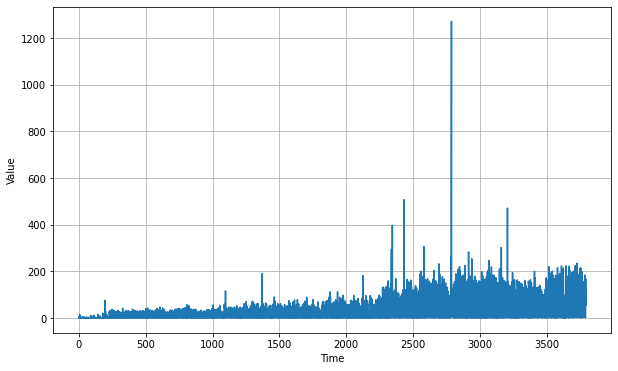

In [6]:
import csv
time_step = []
temps = []

with open('./timeseries_daily.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps).astype("float64")
time = np.array(time_step).astype("float64")
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
time = time[2500:]
series = series[2500:]
time = time-2500

In [8]:
len(time)-1250

45

In [0]:
series[series>300] = 300

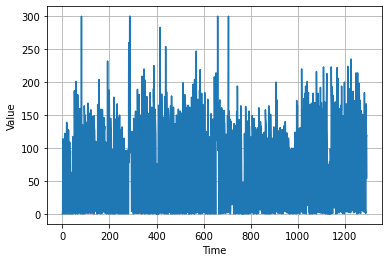

In [10]:
plot_series(time, series)

In [0]:
split_time = 1100
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 100
batch_size = 52
shuffle_buffer_size = 1000

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
#for x,y in ds:
#  print("x= ", x.numpy())

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#window_size = 7*24
#batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(256, activation="relu"),
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 100))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=1, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1100,)
Epoch 1/100
20/20 [==============================] - 1s 48ms/step - loss: 68.8954 - mae: 69.3950 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 1s 46ms/step - loss: 68.7868 - mae: 69.2864 - lr: 1.0233e-08
Epoch 3/100
20/20 [==============================] - 1s 45ms/step - loss: 68.6556 - mae: 69.1551 - lr: 1.0471e-08
Epoch 4/100
20/20 [==============================] - 1s 45ms/step - loss: 68.5190 - mae: 69.0185 - lr: 1.0715e-08
Epoch 5/100
20/20 [==============================] - 1s 45ms/step - loss: 68.3794 - mae: 68.8790 - lr: 1.0965e-08
Epoch 6/100
20/20 [==============================] - 1s 45ms/step - loss: 68.2369 - mae: 68.7364 - lr: 1.1220e-08
Epoch 7/100
20/20 [==============================] - 1s 45ms/step - loss: 68.0917 - mae: 68.5911 - lr: 1.1482e-08
Epoch 8/100
20/20 [==============================] - 1s 46ms/step - loss: 67.9436 - mae: 68.4430 - l

In [15]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 70))
history = model.fit(train_set, epochs=100, verbose=2, callbacks=[lr_schedule])

Epoch 1/100
20/20 - 1s - loss: 52.5951 - mae: 53.0919 - lr: 1.0000e-07
Epoch 2/100
20/20 - 1s - loss: 52.5339 - mae: 53.0306 - lr: 1.0334e-07
Epoch 3/100
20/20 - 1s - loss: 52.4713 - mae: 52.9680 - lr: 1.0680e-07
Epoch 4/100
20/20 - 1s - loss: 52.4080 - mae: 52.9046 - lr: 1.1037e-07
Epoch 5/100
20/20 - 1s - loss: 52.3432 - mae: 52.8398 - lr: 1.1406e-07
Epoch 6/100
20/20 - 1s - loss: 52.2770 - mae: 52.7736 - lr: 1.1788e-07
Epoch 7/100
20/20 - 1s - loss: 52.2096 - mae: 52.7063 - lr: 1.2182e-07
Epoch 8/100
20/20 - 1s - loss: 52.1408 - mae: 52.6376 - lr: 1.2589e-07
Epoch 9/100
20/20 - 1s - loss: 52.0705 - mae: 52.5673 - lr: 1.3010e-07
Epoch 10/100
20/20 - 1s - loss: 51.9980 - mae: 52.4947 - lr: 1.3445e-07
Epoch 11/100
20/20 - 1s - loss: 51.9242 - mae: 52.4208 - lr: 1.3895e-07
Epoch 12/100
20/20 - 1s - loss: 51.8485 - mae: 52.3451 - lr: 1.4360e-07
Epoch 13/100
20/20 - 1s - loss: 51.7707 - mae: 52.2675 - lr: 1.4840e-07
Epoch 14/100
20/20 - 1s - loss: 51.6920 - mae: 52.1889 - lr: 1.5336e-07
E

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 70))
history = model.fit(train_set, epochs=100, verbose=2, callbacks=[lr_schedule])

Epoch 1/100
20/20 - 1s - loss: 25.2848 - mae: 25.7752 - lr: 1.0000e-07
Epoch 2/100
20/20 - 1s - loss: 25.2045 - mae: 25.6949 - lr: 1.0334e-07
Epoch 3/100
20/20 - 1s - loss: 25.1849 - mae: 25.6747 - lr: 1.0680e-07
Epoch 4/100
20/20 - 1s - loss: 25.1731 - mae: 25.6627 - lr: 1.1037e-07
Epoch 5/100
20/20 - 1s - loss: 25.1621 - mae: 25.6518 - lr: 1.1406e-07
Epoch 6/100
20/20 - 1s - loss: 25.1516 - mae: 25.6413 - lr: 1.1788e-07
Epoch 7/100
20/20 - 1s - loss: 25.1406 - mae: 25.6304 - lr: 1.2182e-07
Epoch 8/100
20/20 - 1s - loss: 25.1301 - mae: 25.6195 - lr: 1.2589e-07
Epoch 9/100
20/20 - 1s - loss: 25.1181 - mae: 25.6077 - lr: 1.3010e-07
Epoch 10/100
20/20 - 1s - loss: 25.1056 - mae: 25.5955 - lr: 1.3445e-07
Epoch 11/100
20/20 - 1s - loss: 25.0929 - mae: 25.5827 - lr: 1.3895e-07
Epoch 12/100
20/20 - 1s - loss: 25.0802 - mae: 25.5700 - lr: 1.4360e-07
Epoch 13/100
20/20 - 1s - loss: 25.0667 - mae: 25.5568 - lr: 1.4840e-07
Epoch 14/100
20/20 - 1s - loss: 25.0539 - mae: 25.5437 - lr: 1.5336e-07
E

In [17]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 70))
history = model.fit(train_set, epochs=100, verbose=2, callbacks=[lr_schedule])

Epoch 1/100
20/20 - 1s - loss: 22.0241 - mae: 22.5093 - lr: 1.0000e-06
Epoch 2/100
20/20 - 1s - loss: 21.9929 - mae: 22.4779 - lr: 1.0334e-06
Epoch 3/100
20/20 - 1s - loss: 21.9694 - mae: 22.4544 - lr: 1.0680e-06
Epoch 4/100
20/20 - 1s - loss: 21.9474 - mae: 22.4320 - lr: 1.1037e-06
Epoch 5/100
20/20 - 1s - loss: 21.9305 - mae: 22.4160 - lr: 1.1406e-06
Epoch 6/100
20/20 - 1s - loss: 21.9127 - mae: 22.3979 - lr: 1.1788e-06
Epoch 7/100
20/20 - 1s - loss: 21.9010 - mae: 22.3865 - lr: 1.2182e-06
Epoch 8/100
20/20 - 1s - loss: 21.8614 - mae: 22.3465 - lr: 1.2589e-06
Epoch 9/100
20/20 - 1s - loss: 21.8449 - mae: 22.3305 - lr: 1.3010e-06
Epoch 10/100
20/20 - 1s - loss: 21.8200 - mae: 22.3052 - lr: 1.3445e-06
Epoch 11/100
20/20 - 1s - loss: 21.7870 - mae: 22.2717 - lr: 1.3895e-06
Epoch 12/100
20/20 - 1s - loss: 21.7604 - mae: 22.2454 - lr: 1.4360e-06
Epoch 13/100
20/20 - 1s - loss: 21.7263 - mae: 22.2102 - lr: 1.4840e-06
Epoch 14/100
20/20 - 1s - loss: 21.7127 - mae: 22.1979 - lr: 1.5336e-06
E

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 100))
history = model.fit(train_set, epochs=100, verbose=2, callbacks=[lr_schedule])

Epoch 1/100
20/20 - 1s - loss: 17.3951 - mae: 17.8749 - lr: 1.0000e-05
Epoch 2/100
20/20 - 1s - loss: 16.9607 - mae: 17.4360 - lr: 1.0233e-05
Epoch 3/100
20/20 - 1s - loss: 16.8424 - mae: 17.3148 - lr: 1.0471e-05
Epoch 4/100
20/20 - 1s - loss: 16.7970 - mae: 17.2701 - lr: 1.0715e-05
Epoch 5/100
20/20 - 1s - loss: 16.9111 - mae: 17.3872 - lr: 1.0965e-05
Epoch 6/100
20/20 - 1s - loss: 16.6838 - mae: 17.1560 - lr: 1.1220e-05
Epoch 7/100
20/20 - 1s - loss: 16.6786 - mae: 17.1517 - lr: 1.1482e-05
Epoch 8/100
20/20 - 1s - loss: 16.5920 - mae: 17.0639 - lr: 1.1749e-05
Epoch 9/100
20/20 - 1s - loss: 16.5733 - mae: 17.0462 - lr: 1.2023e-05
Epoch 10/100
20/20 - 1s - loss: 16.5747 - mae: 17.0487 - lr: 1.2303e-05
Epoch 11/100
20/20 - 1s - loss: 16.5715 - mae: 17.0467 - lr: 1.2589e-05
Epoch 12/100
20/20 - 1s - loss: 16.5709 - mae: 17.0460 - lr: 1.2882e-05
Epoch 13/100
20/20 - 1s - loss: 16.4221 - mae: 16.8956 - lr: 1.3183e-05
Epoch 14/100
20/20 - 1s - loss: 16.5998 - mae: 17.0760 - lr: 1.3490e-05
E

In [19]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 100))
history = model.fit(train_set, epochs=100, verbose=2,  callbacks=[lr_schedule])

Epoch 1/100
20/20 - 1s - loss: 15.8674 - mae: 16.3491 - lr: 1.0000e-05
Epoch 2/100
20/20 - 1s - loss: 12.3610 - mae: 12.8286 - lr: 1.0233e-05
Epoch 3/100
20/20 - 1s - loss: 11.5770 - mae: 12.0399 - lr: 1.0471e-05
Epoch 4/100
20/20 - 1s - loss: 11.3586 - mae: 11.8165 - lr: 1.0715e-05
Epoch 5/100
20/20 - 1s - loss: 11.2392 - mae: 11.6932 - lr: 1.0965e-05
Epoch 6/100
20/20 - 1s - loss: 11.1604 - mae: 11.6133 - lr: 1.1220e-05
Epoch 7/100
20/20 - 1s - loss: 11.1047 - mae: 11.5577 - lr: 1.1482e-05
Epoch 8/100
20/20 - 1s - loss: 11.0404 - mae: 11.4929 - lr: 1.1749e-05
Epoch 9/100
20/20 - 1s - loss: 10.9750 - mae: 11.4259 - lr: 1.2023e-05
Epoch 10/100
20/20 - 1s - loss: 10.9201 - mae: 11.3687 - lr: 1.2303e-05
Epoch 11/100
20/20 - 1s - loss: 10.8578 - mae: 11.3050 - lr: 1.2589e-05
Epoch 12/100
20/20 - 1s - loss: 10.8036 - mae: 11.2489 - lr: 1.2882e-05
Epoch 13/100
20/20 - 1s - loss: 10.7539 - mae: 11.1978 - lr: 1.3183e-05
Epoch 14/100
20/20 - 1s - loss: 10.7214 - mae: 11.1664 - lr: 1.3490e-05
E

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]


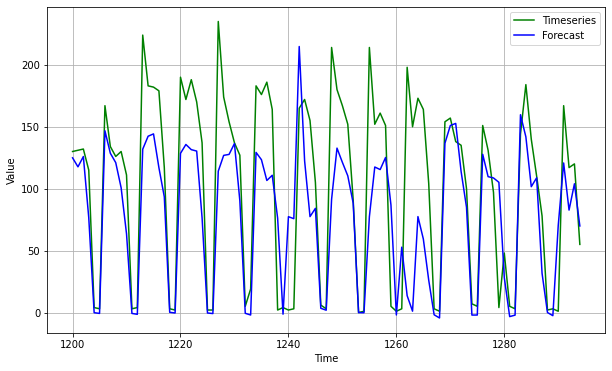

In [21]:
plt.figure(figsize=(10, 6))
start = 100
show_length = 150
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

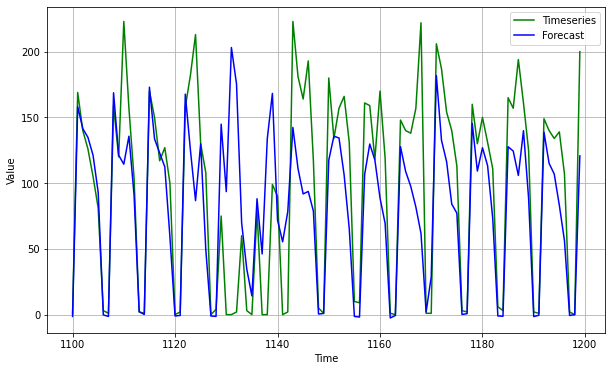

In [22]:
plt.figure(figsize=(10, 6))
start = 0
show_length = 100
plot_series(time_valid[start:start+show_length], x_valid[start:start+show_length],'g')
plot_series(time_valid[start:start+show_length], rnn_forecast[start:start+show_length],'b')
#plot_series(time_valid[0:show_length], rnn_forecast[0:show_length]-x_valid[0:show_length],'r')
plt.legend(["Timeseries","Forecast","Error"])
#plot_series(time_valid, rnn_forecast-x_valid)

In [23]:
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model_daily_v1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_daily_v1.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
%pwd

'/content/drive/My Drive/HackathonKiel'